<a href="https://colab.research.google.com/github/franfgv9/Milestone_1_PLN/blob/main/Tarea_1_proyecto_PLN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==== LIBRERÍAS ====
import pandas as pd
import numpy as np
import re
import unicodedata
import spacy
from tqdm import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords


In [ ]:


# URL "raw" del archivo HateBR.csv en GitHub
url = "https://raw.githubusercontent.com/franfgv9/Milestone_1_PLN/refs/heads/main/HateBR.csv"

# Leer el CSV directamente desde GitHub
df = pd.read_csv(url)

# Verificar la carga
print("Dimensiones del dataset:", df.shape)
print("Columnas disponibles:", df.columns.tolist())
df.head()

Dimensiones del dataset: (7000, 8)
Columnas disponibles: ['id', 'comentario', 'anotator1', 'anotator2', 'anotator3', 'label_final', 'links_post', 'account_post']


,id,comentario,anotator1,anotator2,anotator3,label_final,links_post,account_post
0,1,Mais um lixo,1,1,1,1,https://www.instagram.com/p/B2uThqdH9xI/,Carla Zambelli
1,2,Essa nao tem vergonha na cara!!,1,1,1,1,https://www.instagram.com/p/B2uThqdH9xI/,Carla Zambelli
2,3,Essa mulher é doente.pilantra!,1,1,1,1,https://www.instagram.com/p/B2uThqdH9xI/,Carla Zambelli
3,4,Comunista safada...,1,1,1,1,https://www.instagram.com/p/B2uThqdH9xI/,Carla Zambelli
4,5,Vagabunda. Comunista. Mentirosa. O povo chilen...,1,1,1,1,https://www.instagram.com/p/B2uThqdH9xI/,Carla Zambelli


In [ ]:
# ============================================================
# Seleccionar únicamente las columnas relevantes
# ============================================================

df = df[["id", "comentario", "label_final"]]

# Verificar el resultado
print("Columnas seleccionadas:", df.columns.tolist())
print("Dimensiones del dataset:", df.shape)

df.head()

Columnas seleccionadas: ['id', 'comentario', 'label_final']
Dimensiones del dataset: (7000, 3)


,id,comentario,label_final
0,1,Mais um lixo,1
1,2,Essa nao tem vergonha na cara!!,1
2,3,Essa mulher é doente.pilantra!,1
3,4,Comunista safada...,1
4,5,Vagabunda. Comunista. Mentirosa. O povo chilen...,1


In [ ]:
# ============================================================
# Renombrar las columnas para uniformidad
# ============================================================

df = df.rename(columns={
    "comentario": "text",
    "label_final": "label"
})

print("Columnas finales:", df.columns.tolist())
df.head()

print(df.info())

Columnas finales: ['id', 'text', 'label']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7000 non-null   int64 
 1   text    7000 non-null   object
 2   label   7000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 164.2+ KB
None


In [ ]:
# VEMOS UNA BUENA CANTIDAD DE EJEMPLOS
df.head(30)

,id,text,label
0,1,Mais um lixo,1
1,2,Essa nao tem vergonha na cara!!,1
2,3,Essa mulher é doente.pilantra!,1
3,4,Comunista safada...,1
4,5,Vagabunda. Comunista. Mentirosa. O povo chilen...,1
5,6,"COMUNISTA SAFADA, MALPARIDA, MAMAGUEVA, DESGRA...",1
6,7,Besta quadrada.,1
7,8,Se elegeu as nossas custas,1
8,9,Comunista lixo!,1
9,10,"Quem tem pena é galinha, mas ela é uma VACA LO...",1



Número de ejemplos por clase:
label
0    3500
1    3500
Name: count, dtype: int64

Porcentaje de clases:
label
0    50.0
1    50.0
Name: count, dtype: float64


/tmp/ipython-input-349352734.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_labels, y=class_counts.values, palette="pastel")


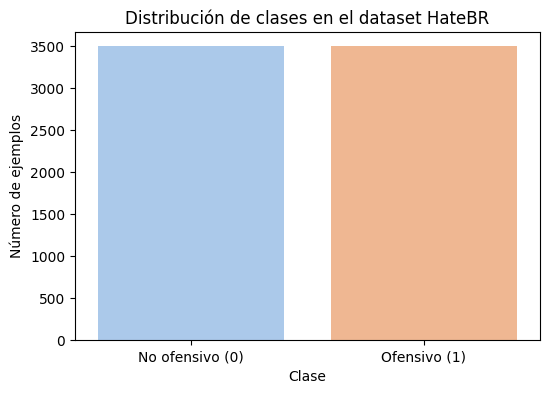

In [ ]:
# ============================================================
# 1. Exploración de clases
# ============================================================



# Conteo de clases
class_counts = df["label"].value_counts().sort_index()      # cuenta cuantos valores por clase (en este caso 0:3500 y 1:3500) y los ordena --> primero 0 luego 1
class_labels = ["No ofensivo (0)", "Ofensivo (1)"]

print("\nNúmero de ejemplos por clase:")
print(class_counts)

# Porcentaje de cada clase
percentages = (class_counts / len(df) * 100).round(2)
print("\nPorcentaje de clases:")
print(percentages)

# ============================================================
# 2. Visualización de la distribución
# ============================================================

plt.figure(figsize=(6,4))
sns.barplot(x=class_labels, y=class_counts.values, palette="pastel")
plt.title("Distribución de clases en el dataset HateBR")
plt.ylabel("Número de ejemplos")
plt.xlabel("Clase")
plt.show()

In [ ]:
# Longitud media de los comentarios
df['word_count'] = df['text'].str.split().apply(len)
df.groupby('label')['word_count'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,3500.0,12.522571,13.178434,1.0,5.0,8.0,15.0,171.0
1,3500.0,15.345143,15.536119,1.0,6.0,10.5,19.0,189.0


Shorter comments tend to be harmless, although not by a wide margin.

**What you do:**
Check whether offensive comments tend to be shorter or longer.

**What you look for:**
If offensive ones are brief (“lixo”, “burro”, “vai embora”), you could create a rule based on brevity + insult.

**Possible rule:**
If the comment has fewer than 5 words and contains an offensive word → probably offensive.



In [ ]:
# Presencia de menciones (@usuario)
df['has_mention'] = df['text'].str.contains('@')
df.groupby('has_mention')['label'].value_counts(normalize=True)

has_mention  label
False        1        0.509271
             0        0.490729
True         0        0.613636
             1        0.386364
Name: proportion, dtype: float64

We see that 61% of people who tag someone in their comments do so because it’s not offensive.


In [ ]:
# Presencia de hastags (#)
df['has_hastag'] = df['text'].str.contains('#')
df.groupby('has_hastag')['label'].value_counts(normalize=True)

has_hastag  label
False       0        0.502853
            1        0.497147
True        1        0.618182
            0        0.381818
Name: proportion, dtype: float64

In [ ]:
# Presencia de URLs
df['has_url'] = df['text'].str.contains(r'http|www', case=False)
df.groupby('has_url')['label'].value_counts(normalize=True)


has_url  label
False    0        0.500071
         1        0.499929
True     1        0.666667
         0        0.333333
Name: proportion, dtype: float64

Here the opposite happens: posts that contain URLs have a 66% chance of being offensive.


In [ ]:
# Presencia de emojis

emoji_pattern = re.compile("[\U00010000-\U0010ffff]", flags=re.UNICODE)
df['has_emoji'] = df['text'].apply(lambda x: bool(emoji_pattern.search(x)))
df.groupby('has_emoji')['label'].value_counts(normalize=True)

has_emoji  label
False      1        0.549952
           0        0.450048
True       0        0.639566
           1        0.360434
Name: proportion, dtype: float64

Most comments with emojis are harmless.


In [ ]:
# Uso de mayúsculas
df['caps_ratio'] = df['text'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x)>0 else 0)
df.groupby('label')['caps_ratio'].mean()

,caps_ratio
label,
0,0.059868
1,0.074745


Offensive comments (label = 1) have, on average (7.4%), more capital letters than non-offensive ones (5.9%).

Although the difference isn’t huge, there’s a clear trend:
users tend to use more capital letters when writing aggressive or emotional messages.


ChatGPT Plus

This feature could serve as a complementary rule in your Milestone 1 (rule-based system).

Example of a simple rule:

if caps_ratio > 0.08:
    label = 1  # probably offensive


It shouldn’t be used on its own (since there are non-offensive messages in uppercase, like “FELIZ ANIVERSÁRIO!”),
but when combined with other signals (insults, exclamations, mentions), it can improve accuracy.

In [ ]:

nltk.download('stopwords')


stopwords_pt = set(stopwords.words('portuguese'))

def clean_and_tokenize(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar signos de puntuación y números
    text = re.sub(r'[^a-záéíóúàâêôãõç\s]', '', text)
    # Tokenizar
    words = text.split()
    # Filtrar stopwords
    return [w for w in words if w not in stopwords_pt and len(w) > 2]

# Ofensivos
offensive_tokens = df[df['label']==1]['text'].apply(clean_and_tokenize).sum()
offensive_words = Counter(offensive_tokens).most_common(20)

# No ofensivos
non_offensive_tokens = df[df['label']==0]['text'].apply(clean_and_tokenize).sum()
non_offensive_words = Counter(non_offensive_tokens).most_common(20)

print("Palabras más comunes (ofensivos):", offensive_words)
print("Palabras más comunes (no ofensivos):", non_offensive_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Palabras más comunes (ofensivos): [('pra', 351), ('vai', 264), ('brasil', 226), ('cara', 186), ('presidente', 160), ('povo', 155), ('vergonha', 154), ('esquerda', 141), ('lixo', 132), ('nada', 130), ('pirralha', 130), ('país', 127), ('lula', 126), ('bolsonaro', 119), ('desse', 117), ('ainda', 115), ('deus', 113), ('todos', 110), ('fazer', 109), ('tudo', 109)]
Palabras más comunes (no ofensivos): [('presidente', 352), ('parabéns', 323), ('deus', 284), ('brasil', 261), ('pra', 171), ('bolsonaro', 165), ('sempre', 135), ('bem', 128), ('lula', 123), ('melhor', 122), ('todos', 120), ('vai', 119), ('ter', 107), ('haddad', 107), ('país', 105), ('povo', 103), ('tudo', 99), ('vamos', 89), ('mulher', 85), ('grande', 77)]


Common words that appear only in offensive comments can be useful as rules.


In [ ]:

df['has_repetition'] = df['text'].apply(lambda x: bool(re.search(r'(.)\1{2,}', x)))
df.groupby('has_repetition')['label'].value_counts(normalize=True)

has_repetition  label
False           0        0.500907
                1        0.499093
True            1        0.502205
                0        0.497795
Name: proportion, dtype: float64

**What you do:**
Detect sequences with the same letter repeated more than twice ("nooossaaaa", "liiiindooo").

**What you look for:**
If they’re more common in offensive comments, they reflect sarcasm, irony, or exaggerated emotion.

If not, you can remove them during cleaning.

**Possible rule:**
If the text contains exaggerated repetitions → add a small weight to the offensive category.


In [ ]:
# Uso de signos de interrogación
df['question_count'] = df['text'].str.count('\?')
df.groupby('label')['question_count'].mean()

<>:2: SyntaxWarning: invalid escape sequence '\?'
<>:2: SyntaxWarning: invalid escape sequence '\?'
/tmp/ipython-input-3284096510.py:2: SyntaxWarning: invalid escape sequence '\?'
  df['question_count'] = df['text'].str.count('\?')


,question_count
label,
0,0.163143
1,0.205429


**What you do:**
Count how many `?` appear in each text.

**What you look for:**
Some offensive comments may use many rhetorical questions (“quem te perguntou???”).

If you see a clear pattern, you could keep these symbols as a feature of irony or aggression.

**Possible rule:**
If a text contains multiple consecutive question marks, it may be mocking or challenging → offensive.


We can see that there are more offensive comments containing "?" than non-offensive ones, leading to the hypothesis and a possible rule regarding mockery or irony.


In [ ]:
# Presencia de pronombres de segunda persona
pronouns = ['você', 'tu', 'teu', 'seu', 'vc']
df['has_2nd_person'] = df['text'].apply(lambda x: any(p in x.lower() for p in pronouns))
df.groupby('has_2nd_person')['label'].value_counts(normalize=True)

has_2nd_person  label
False           1        0.501444
                0        0.498556
True            0        0.505479
                1        0.494521
Name: proportion, dtype: float64

**What you do:**
Look for words like “você”, “tu”, “seu”, “teu”.

**What you look for:**
Direct attacks (“você é um idiota”) → more common in offensive comments.

**Possible rule:**
If it contains a second-person pronoun + a negative word → offensive.




Vemos que no hay diferencia a penas, aunque si lo combinamos de un insulto puede convertirse en una regla bastante clara

Once we have these results, we’re going to perform data cleaning.

For this, we’ve realized that we should do the following:

1. Keep capital letters.
2. Remove unnecessary punctuation (keep `?`).
3. Remove non-alphabetic characters or multiple spaces.
4. Keep emojis, mentions, and hashtags.

However, I won’t remove stopwords or perform lemmatization yet because I’ll use later linguistic analysis with spaCy, as that library can benefit from seeing the full text.


In [ ]:


def clean_text_preserve_case_emojis_questions(text):
    # 1️⃣ Eliminar puntuación innecesaria (pero mantener ?, @, # y emojis)
    # Quitamos comas, puntos, signos innecesarios, pero dejamos interrogaciones y símbolos expresivos
    text = re.sub(r'[!"$%&\'()*+,\-./:;<=>\[\]\\^_`{|}~]', ' ', text)

    # 2️⃣ Mantener letras (mayúsculas y minúsculas), acentos, emojis, @, # y signos de interrogación
    text = re.sub(
        r'[^A-Za-zÁÉÍÓÚÀÂÊÔÃÕÇáéíóúàâêôãõç@#\? '
        r'\U0001F300-\U0001F5FF'
        r'\U0001F600-\U0001F64F'
        r'\U0001F900-\U0001FAFF'
        r'\U00002700-\U000027BF]',
        ' ', text
    )

    # 3️⃣ Reemplazar espacios múltiples por uno solo
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Aplicar al DataFrame
df['clean_text'] = df['text'].apply(clean_text_preserve_case_emojis_questions)

# Ver resultados
df[['text', 'clean_text']].head(25)


,text,clean_text
0,Mais um lixo,Mais um lixo
1,Essa nao tem vergonha na cara!!,Essa nao tem vergonha na cara
2,Essa mulher é doente.pilantra!,Essa mulher é doente pilantra
3,Comunista safada...,Comunista safada
4,Vagabunda. Comunista. Mentirosa. O povo chilen...,Vagabunda Comunista Mentirosa O povo chileno n...
5,"COMUNISTA SAFADA, MALPARIDA, MAMAGUEVA, DESGRA...",COMUNISTA SAFADA MALPARIDA MAMAGUEVA DESGRAÇAD...
6,Besta quadrada.,Besta quadrada
7,Se elegeu as nossas custas,Se elegeu as nossas custas
8,Comunista lixo!,Comunista lixo
9,"Quem tem pena é galinha, mas ela é uma VACA LO...",Quem tem pena é galinha mas ela é uma VACA LOUCA


In [ ]:
!pip install spacy
!python -m spacy download pt_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 21.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Procesar tu texto con spaCy


# Cargar modelo de portugués
nlp = spacy.load("pt_core_news_md")

# Procesar un ejemplo (puedes hacerlo sobre un subconjunto del dataset para exploración)
example = df['clean_text'].iloc[0]
doc = nlp(example)

# Mostrar análisis básico
for token in doc:
    print(f"{token.text:<15}  | POS: {token.pos_:<10} | Lemma: {token.lemma_:<15} | Dep: {token.dep_}")

Mais             | POS: ADV        | Lemma: mais            | Dep: advmod
um               | POS: NUM        | Lemma: um              | Dep: nummod
lixo             | POS: NOUN       | Lemma: lixo            | Dep: ROOT


In [ ]:
# Extraer entidades (NER)
for ent in doc.ents:
    print(f"Entidad: {ent.text:<20} | Tipo: {ent.label_}")

In [ ]:
# spaCy no incluye sentimiento nativo en portugués, pero puedes añadirlo fácilmente con spacytextblob
!pip install spacytextblob

In [ ]:
# Análisis de sentimiento
from spacytextblob.spacytextblob import SpacyTextBlob

nlp.add_pipe("spacytextblob")

doc = nlp(example)
print("Polaridad:", doc._.blob.polarity)


Polaridad: 0.0


**Objective**

Process only a subset of the dataset (for example, 20 comments) with spaCy to:

* Obtain their tokens, lemmas, and part-of-speech (POS) tags.
* Save that information in new DataFrame columns.
* Start looking for linguistic patterns between offensive and non-offensive comments.


In [ ]:

from tqdm import tqdm  # Para barra de progreso (opcional)
tqdm.pandas()          # Permite usar progress_apply

# Cargar el modelo portugués de spaCy
nlp = spacy.load("pt_core_news_md")

# Tomamos un subconjunto (por ejemplo, las primeras 20 filas)
subset = df.head(20).copy()

# Función que procesa un texto y devuelve info lingüística básica
def extract_linguistic_features(text):
    doc = nlp(text)
    return {
        "tokens": [token.text for token in doc],
        "lemmas": [token.lemma_ for token in doc],
        "pos": [token.pos_ for token in doc]
    }

# Aplicamos la función con barra de progreso
subset["linguistic_info"] = subset["clean_text"].progress_apply(extract_linguistic_features)

# Desglosamos la información en columnas individuales
subset["tokens"] = subset["linguistic_info"].apply(lambda x: x["tokens"])
subset["lemmas"] = subset["linguistic_info"].apply(lambda x: x["lemmas"])
subset["pos_tags"] = subset["linguistic_info"].apply(lambda x: x["pos"])

# Mostramos el resultado
subset[["label", "clean_text", "tokens", "lemmas", "pos_tags"]].head(20)

100%|██████████| 20/20 [00:00<00:00, 70.27it/s]


,label,clean_text,tokens,lemmas,pos_tags
0,1,Mais um lixo,"[Mais, um, lixo]","[mais, um, lixo]","[ADV, NUM, NOUN]"
1,1,Essa nao tem vergonha na cara,"[Essa, nao, tem, vergonha, na, cara]","[esse, nao, ter, vergonha, em o, cara]","[DET, PROPN, VERB, NOUN, ADP, NOUN]"
2,1,Essa mulher é doente pilantra,"[Essa, mulher, é, doente, pilantra]","[esse, mulher, ser, doente, pilantra]","[DET, NOUN, AUX, ADJ, ADJ]"
3,1,Comunista safada,"[Comunista, safada]","[comunista, safar]","[NOUN, VERB]"
4,1,Vagabunda Comunista Mentirosa O povo chileno n...,"[Vagabunda, Comunista, Mentirosa, O, povo, chi...","[Vagabunda, Comunista, Mentirosa, o, povo, chi...","[PROPN, PROPN, PROPN, DET, NOUN, ADJ, PROPN, V..."
5,1,COMUNISTA SAFADA MALPARIDA MAMAGUEVA DESGRAÇAD...,"[COMUNISTA, SAFADA, MALPARIDA, MAMAGUEVA, DESG...","[COMUNISTA, SAFADA, MALPARIDA, MAMAGUEVA, DESG...","[PROPN, VERB, PROPN, PROPN, PROPN, PROPN, DET,..."
6,1,Besta quadrada,"[Besta, quadrada]","[Besta, quadrar]","[ADJ, VERB]"
7,1,Se elegeu as nossas custas,"[Se, elegeu, as, nossas, custas]","[se, elegeu, o, nosso, custa]","[SCONJ, VERB, DET, DET, NOUN]"
8,1,Comunista lixo,"[Comunista, lixo]","[comunista, lixo]","[ADJ, ADJ]"
9,1,Quem tem pena é galinha mas ela é uma VACA LOUCA,"[Quem, tem, pena, é, galinha, mas, ela, é, uma...","[quem, ter, pena, ser, galinha, mas, ela, ser,...","[PRON, VERB, NOUN, AUX, ADJ, CCONJ, PRON, AUX,..."


In [ ]:
import itertools
from collections import Counter

offensive_pos = list(itertools.chain.from_iterable(subset[subset['label']==1]['pos_tags']))
non_offensive_pos = list(itertools.chain.from_iterable(subset[subset['label']==0]['pos_tags']))

print("POS más comunes (ofensivos):", Counter(offensive_pos).most_common(5))
print("POS más comunes (inofensivos):", Counter(non_offensive_pos).most_common(5))

POS más comunes (ofensivos): [('NOUN', 32), ('VERB', 27), ('DET', 19), ('PROPN', 15), ('ADP', 14)]
POS más comunes (inofensivos): []


**Objective**

We want to know what percentage of offensive comments in the dataset contain at least one “NOUN + ADJ” sequence (noun followed by adjective).

**Example of this pattern:**

* “Homem burro”
* “Político corrupto”
* “Cara ridículo”

→ all are possible offensive cases.


In [ ]:


# Cargar modelo portugués
nlp = spacy.load("pt_core_news_md")
tqdm.pandas()

# Subconjunto (para empezar, 200 comentarios)
subset = df.head(200).copy()

# Función para comprobar si hay patrón NOUN + ADJ en el texto
def has_noun_adj_pattern(text):
    doc = nlp(text)
    for i in range(len(doc)-1):
        if doc[i].pos_ == "NOUN" and doc[i+1].pos_ == "ADJ":
            return True
    return False

# Aplicar la función al dataset
subset['has_noun_adj'] = subset['clean_text'].progress_apply(has_noun_adj_pattern)

# Calcular porcentaje en ofensivos
offensive_subset = subset[subset['label'] == 1]
percent_with_pattern = offensive_subset['has_noun_adj'].mean() * 100

print(f"➡️ Porcentaje de comentarios ofensivos con patrón NOUN + ADJ: {percent_with_pattern:.2f}%")

100%|██████████| 200/200 [00:02<00:00, 80.28it/s] 

➡️ Porcentaje de comentarios ofensivos con patrón NOUN + ADJ: 25.00%


In [ ]:
import spacy
from tqdm import tqdm

# Cargar modelo portugués
nlp = spacy.load("pt_core_news_md")
tqdm.pandas()

# Subconjunto (ej. 200 comentarios)
subset = df.head(200).copy()

# Lista de pronombres de 2ª persona (puedes ampliar)
second_person_pronouns = ["você", "vc", "tu", "teu", "seu", "sua", "vocês"]

# Lista de adjetivos negativos comunes (puedes ampliarla con los que detectes en tu EDA)
negative_adjectives = [
    "burro", "idiota", "nojento", "ridículo", "feio", "lixo", "otário",
    "canalha", "estúpido", "corrupto", "inútil", "vergonhoso"
]

# Función para detectar patrón
def has_second_person_and_negative_adj(text):
    doc = nlp(text)
    has_pronoun = any(token.text.lower() in second_person_pronouns for token in doc)
    has_neg_adj = any(token.text.lower() in negative_adjectives and token.pos_ == "ADJ" for token in doc)
    return has_pronoun and has_neg_adj

# Aplicar función al subconjunto
subset['has_2p_negadj'] = subset['clean_text'].progress_apply(has_second_person_and_negative_adj)

# Calcular porcentaje en ofensivos
offensive_subset = subset[subset['label'] == 1]
percent_with_pattern = offensive_subset['has_2p_negadj'].mean() * 100

print(f"➡️ Porcentaje de comentarios ofensivos con pronombre 2ª persona + adjetivo negativo: {percent_with_pattern:.2f}%")

100%|██████████| 200/200 [00:01<00:00, 113.76it/s]

➡️ Porcentaje de comentarios ofensivos con pronombre 2ª persona + adjetivo negativo: 0.00%


To complete the set of negative adjectives, we will do the following:


In [ ]:


# Cargar el modelo portugués de spaCy
nlp = spacy.load("pt_core_news_md")
tqdm.pandas()

# Subconjunto para no saturar memoria (puedes aumentar a 1000 o más)
subset = df[df['label'] == 1].head(1000).copy()  # solo comentarios ofensivos

# Función para extraer adjetivos de un texto
def extract_adjectives(text):
    doc = nlp(text)
    return [token.text.lower() for token in doc if token.pos_ == "ADJ"]

# Aplicar la función
subset["adjectives"] = subset["clean_text"].progress_apply(extract_adjectives)

# Unir todos los adjetivos en una lista
all_adjs = [adj for adjs in subset["adjectives"] for adj in adjs]

# Contar los más comunes
adj_counter = Counter(all_adjs)
common_adjs = adj_counter.most_common(30)

# Mostrar los 30 adjetivos más frecuentes en comentarios ofensivos
for word, count in common_adjs:
    print(f"{word:<15} {count}")


100%|██████████| 1000/1000 [00:17<00:00, 55.99it/s]

globolixo       33
lixo            28
idiota          16
corrupta        14
comunista       11
velha           11
grande          10
igual           9
nojenta         9
podre           9
nacional        9
🤬               9
ridícula        8
mesmo           8
imbecil         8
pior            8
nojento         7
triste          7
brasileira      7
ridículo        7
doente          6
certo           6
esquerdista     6
bom             6
mesma           6
😂               6
kkkk            6
🏻               6
brasileiro      6
globo           6


In [ ]:


# Cargar modelo portugués
nlp = spacy.load("pt_core_news_md")
tqdm.pandas()

# Subconjunto (ej. 200 comentarios)
subset = df.head(1000).copy()

# Lista de pronombres de 2ª persona (puedes ampliar)
second_person_pronouns = ["você", "vc", "tu", "teu", "seu", "sua", "vocês"]

# Función para detectar patrón
def has_second_person_and_negative_adj(text):
    doc = nlp(text)
    has_pronoun = any(token.text.lower() in second_person_pronouns for token in doc)
    has_neg_adj = any(token.text.lower() in all_adjs and token.pos_ == "ADJ" for token in doc)
    return has_pronoun and has_neg_adj

# Aplicar función al subconjunto
subset['has_2p_negadj'] = subset['clean_text'].progress_apply(has_second_person_and_negative_adj)

# Calcular porcentaje en ofensivos
offensive_subset = subset[subset['label'] == 1]
percent_with_pattern = offensive_subset['has_2p_negadj'].mean() * 100

print(f"➡️ Porcentaje de comentarios ofensivos con pronombre 2ª persona + adjetivo negativo: {percent_with_pattern:.2f}%")

100%|██████████| 1000/1000 [00:10<00:00, 96.89it/s]

➡️ Porcentaje de comentarios ofensivos con pronombre 2ª persona + adjetivo negativo: 6.50%


To create the vocabulary of offensive words or words also considered insults, we will:

1. **LEXICAL APPROACH** — Dictionaries or lists of insults → Define a list (lexicon) of known offensive words or insults in Portuguese (manual or semi-automatic).

2. **STATISTICAL APPROACH** — Data from the HateBR corpus → Use dataset information to detect words that appear much more frequently in offensive texts than in non-offensive ones.


In [ ]:

import itertools

# MÉTODO 1: Lista manual inicial (puedes ampliarla con tus conocimientos)
manual_insults = [
    "idiota", "burro", "nojento", "lixo", "otário", "imbecil",
    "canalha", "estúpido", "vagabundo", "inútil", "corrupto", "palhaço",
    "vergonhoso", "mentiroso", "maucaráter", "asqueroso","otario", "babaca", "ridículo", "ridiculo", "idiotice", "besta", "merda",
    "bosta", "fdp", "filhodaputa", "filhodaputa", "arrombado", "vagabunda",
    "pilantra", "miserável", "miseravel", "traidor", "nojenta", "verme",
    "safado", "doente", "covarde", "cretino", "canalha", "porco",
    "gordo", "gorda", "velho", "velha", "feio", "feia", "burra",
    "retardado", "animal", "monstro", "asquerosa", "falso", "falsos",
    "macaco", "otária", "otaria", "pobre", "escroto", "escrota",
    "vaca", "puta", "ladrão", "ladrao", "paspalho", "incompetente",
    "nojentinho", "nojentona", "moleque", "semvergonha", "corno", "boçal",
    "idiotão", "doidinho", "maluco", "imbecis", "burros", "idiotas"

]

print(f" Lista inicial (manual): {len(manual_insults)} insultos")

#  MÉTODO 3: Descubrir nuevas palabras asociadas a ofensas en HateBR

#  Tokenizar todos los textos ofensivos y no ofensivos
offensive_words = list(itertools.chain.from_iterable(
    df[df['label']==1]['clean_text'].str.split()
))
non_offensive_words = list(itertools.chain.from_iterable(
    df[df['label']==0]['clean_text'].str.split()
))

#  Contar frecuencia de aparición de cada palabra
off_counter = Counter(offensive_words)
nonoff_counter = Counter(non_offensive_words)

# Calcular ratio ofensivo: frecuencia en ofensivos / frecuencia total
offensive_ratio = {}
for word in off_counter:
    total = off_counter[word] + nonoff_counter.get(word, 0)
    if total > 5:  # ignorar palabras muy raras
        offensive_ratio[word] = off_counter[word] / total

#  Ordenar por "fuerza ofensiva"
ranked_offensive = sorted(offensive_ratio.items(), key=lambda x: x[1], reverse=True)

#  Seleccionar las palabras más asociadas a ofensivos
# (por ejemplo, aquellas con ratio > 0.8 y más de 5 apariciones)
auto_insults = [w for w, r in ranked_offensive if r > 0.8 and off_counter[w] > 5]

print(f" Palabras añadidas automáticamente del corpus: {len(auto_insults)}")
print(auto_insults[:20])  # ver las primeras

# 🧩 COMBINAR AMBAS LISTAS (manual + automáticas)
hybrid_insults = sorted(set(manual_insults + auto_insults))

print(f"\n Total de insultos en tu lista híbrida: {len(hybrid_insults)}")
print(hybrid_insults[:30])  # muestra los primeros 30


 Lista inicial (manual): 78 insultos
 Palabras añadidas automáticamente del corpus: 360
['doente', 'pilantra', 'Comunista', 'safada', 'Vagabunda', 'COMUNISTA', 'custas', 'pariu', 'bandida', 'roubar', 'Nojo', 'hipocrisia', 'Velha', 'idiota', 'CANALHA', 'nojenta', 'moral', 'ridícula', 'comunistas', 'Esquerdista']

 Total de insultos en tu lista híbrida: 403
['#globolixo', 'AINDA', 'AOS', 'AS', 'Absurdo', 'Acorda', 'BANDIDO', 'BOZOLOIDE', 'Bachelet', 'Bandido', 'Bando', 'Bozo', 'CADEIA', 'CANALHA', 'CARA', 'CHEGA', 'COMUNISTA', 'CONTRA', 'Cadeia', 'Cala', 'Cambada', 'Canalha', 'Chile', 'Chupa', 'Comunista', 'Congresso', 'Cuba', 'DEVERIA', 'Deveriam', 'Devia']


Then we will perform a sweep to clean our insults vocabulary.


In [ ]:


# Descargar stopwords en portugués
nltk.download('stopwords')
stopwords_pt = set(stopwords.words('portuguese'))

# --- Limpiar la lista híbrida ---
cleaned_insults = []

for w in hybrid_insults:
    # Convertir a minúsculas y eliminar espacios extra
    word = w.strip().lower()

    # Eliminar palabras vacías (stopwords)
    if word.lower() in stopwords_pt:
        continue

    # Eliminar palabras muy cortas o numéricas
    if len(word) < 3 or word.isnumeric():
        continue
    cleaned_insults.append(word)

# --- Quitar duplicados y ordenar ---
cleaned_insults = sorted(set(cleaned_insults))

print(f" Lista final de insultos filtrados: {len(cleaned_insults)} palabras")
print(cleaned_insults[:50])  # muestra las primeras 50


📘 Lista final de insultos filtrados: 326 palabras
['#globolixo', 'absurda', 'absurdo', 'acha', 'acorda', 'acredita', 'aguento', 'ainda', 'anda', 'animal', 'arrombado', 'asquerosa', 'asqueroso', 'ataca', 'atacar', 'babaca', 'bachelet', 'bandida', 'bandidagem', 'bandido', 'bandidos', 'bando', 'besta', 'besteira', 'boca', 'bosta', 'botar', 'bozo', 'bozoloide', 'boçal', 'bunda', 'burra', 'burrice', 'burro', 'burros', 'cachorro', 'cadeia', 'caduco', 'cair', 'cala', 'calados', 'cambada', 'canalha', 'canalhas', 'cansa', 'capeta', 'cara', 'caralho', 'carniça', 'chamada']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We see that, despite everything, there are words that don’t have to be insults, so in the rules this should be combined with grammatical combinations such as:

1. **NOUN + ADJ** → direct insult (“lixo humano”).
2. **VERB + PRON** → attack or command (“vai embora”, “cala a boca”).


Now we’re going to enrich our insults vocabulary with n-grams, but we’ll put these in a separate vocabulary since most of the time a word from this set in our text is really an insult.

**OBJECTIVE**

Extract the most frequent n-grams in offensive comments and add those that seem offensive or aggressive to your list of expressions. Since these are full expressions, there’s no need to clean or filter these comments.

With them, we can create robust rules:

* “If any of the tokens contained in `hybrid_insults_expanded` appear, classify the comment directly as offensive.”

Clearly, this rule should have a high level of priority or activation in case of rule conflicts.


In [ ]:

from nltk.util import ngrams
from nltk.corpus import stopwords


nltk.download('stopwords')
stopwords_pt = set(stopwords.words('portuguese'))

# --- FUNCIONES AUXILIARES ---
def get_ngrams(texts, n=2, min_freq=5):
    """Genera n-gramas frecuentes filtrando stopwords."""
    all_ngrams = []
    for text in texts:
        tokens = [t.lower() for t in text.split() if t.lower() not in stopwords_pt]
        all_ngrams.extend([' '.join(gram) for gram in ngrams(tokens, n)])
    counts = Counter(all_ngrams)
    return [ng for ng, freq in counts.items() if freq >= min_freq]

# ---  OBTENER BIGRAMAS Y TRIGRAMAS OFENSIVOS ---
offensive_texts = df[df['label'] == 1]['clean_text']

bigrams_list = get_ngrams(offensive_texts, n=2, min_freq=5)
trigrams_list = get_ngrams(offensive_texts, n=3, min_freq=3)

print(f"🔹 Bigramas detectados: {len(bigrams_list)}")
print(f"🔹 Trigramas detectados: {len(trigrams_list)}")

# --- UNIFICAR TODO EL VOCABULARIO ---
# (palabras individuales + bigramas + trigramas)
hybrid_insults_expanded = sorted(set(bigrams_list + trigrams_list))

print(f"\n Total del vocabulario ofensivo ampliado: {len(hybrid_insults_expanded)}")
print(hybrid_insults_expanded[:40])  # mostrar ejemplos

🔹 Bigramas detectados: 127
🔹 Trigramas detectados: 33

📘 Total del vocabulario ofensivo ampliado: 160
['@carla zambelli', 'acima tudo', 'acorda brasil', 'ainda bem', 'ainda bem q', 'alguma coisa', 'alguma coisa útil', 'amor deus', 'aqui brasil', 'aí vai', 'bem feito', 'bem feito pra', 'blog tic tac', 'boca pra falar', 'bolsonaro vai', 'bolsonaro vai tomar', 'brasil acima tudo', 'brasil precisa', 'cada dia', 'cada vez', 'cala boca', 'cansa passar', 'cansa passar vergonha', 'cansam passar vergonha', 'cara desse', 'cara pau', 'carta capital', 'chega chega', 'chega chega chega', 'cidadão bem', 'congresso nacional', 'congresso stf', 'contra governo', 'dar ibope pra', 'deputados senadores', 'desse cara', 'deve ter', 'deveria ter', 'deveria ter saído', 'devia ter']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


However, we need to adjust this a bit to make it a reliable rule, because some bigrams/trigrams aren’t offensive, like “ainda bem”, “bem feito”, etc.


**WHAT THIS CODE DOES**

**Stes:**

* Selects only offensive texts (label == 1).
* Generates n-grams (combinations of 2 or 3 consecutive words).
* Filters out stopwords so that combinations like “de o”, “em a” don’t appear.
* Counts the frequency and shows the most common ones.


Analyze grammatical combinations:

* **NOUN + ADJ** → direct insult (“lixo humano”).
* **VERB + PRON** → attack or command (“vai embora”, “cala a boca”).


In [ ]:

tqdm.pandas()

# Descargar el modelo de portugués si no está instalado (ejecuta esto una vez)
#!python -m spacy download pt_core_news_sm

# Funciones de limpieza (definidas para evitar NameError)
def deaccent(text):
    nfkd = unicodedata.normalize('NFD', str(text))
    return ''.join([c for c in nfkd if not unicodedata.combining(c)])

def basic_clean(text):
    text = str(text)
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"[^\w\s@#?]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    text = deaccent(text)
    return text

def tokenize(text):
    return re.findall(r"@[A-Za-z0-9_]+|#[A-Za-z0-9_]+|\w+|\?", text, flags=re.UNICODE)

# Definir spaCy con el modelo descargado
nlp = spacy.load('pt_core_news_sm')

# Función corregida (con verificación de negaciones para reducir falsos positivos)
def has_noun_adj_pattern(text, pre_tokenized=None):
    """Devuelve True si el texto contiene un patrón sustantivo + adjetivo donde al menos uno es un insulto no negado"""
    # Preprocesar el texto si no se proporcionan tokens
    if pre_tokenized is None:
        cleaned_text = basic_clean(text)
    else:
        cleaned_text = ' '.join(pre_tokenized)  # Reconstruir texto para spaCy

    # Procesar con spaCy
    doc = nlp(cleaned_text)

    # Verificar patrón NOUN + ADJ
    for i in range(len(doc) - 1):
        if doc[i].pos_ == "NOUN" and doc[i+1].pos_ == "ADJ":
            # Verificar si alguno de los tokens es un insulto
            if (doc[i].lemma_.lower() in hybrid_insults or
                doc[i+1].lemma_.lower() in hybrid_insults):
                # Verificar que el insulto no esté negado
                tokens = pre_tokenized if pre_tokenized is not None else tokenize(cleaned_text)
                insult_idx = max(0, i - 2)  # Buscar negaciones en las 2 posiciones previas
                prev_tokens = tokens[max(0, insult_idx - 2):insult_idx + 2]
                negations = ['nao', 'não', 'nunca', 'jamais']
                if not any(p.lower() in negations for p in prev_tokens):
                    return True
    return False

# Aplicar a df (usar 'text' en lugar de 'clean_text')
df['noun_adj_pattern'] = df['text'].progress_apply(has_noun_adj_pattern)

100%|██████████| 7000/7000 [01:09<00:00, 100.05it/s]


**What it does:**

* Searches for a noun + adjective sequence.
* If either word appears in your insults list → marks it as a potential direct insult.


In [ ]:

# Función corregida y simplificada
def has_verb_pron_pattern(text, pre_tokenized=None):
    """Devuelve True si el texto contiene un patrón verbo + pronombre donde al menos uno es un insulto no negado"""
    # Preprocesar el texto si no se proporcionan tokens
    if pre_tokenized is None:
        cleaned_text = basic_clean(text)
    else:
        cleaned_text = ' '.join(pre_tokenized)  # Reconstruir texto para spaCy

    # Procesar con spaCy
    doc = nlp(cleaned_text)

    # Verificar patrón VERB + PRON
    for i in range(len(doc) - 1):
        if doc[i].pos_ == "VERB" and doc[i+1].pos_ == "PRON":
            # Verificar si alguno de los tokens es un insulto
            if (doc[i].lemma_.lower() in hybrid_insults or
                doc[i+1].lemma_.lower() in hybrid_insults):
                # Verificar que el insulto no esté negado
                tokens = pre_tokenized if pre_tokenized is not None else tokenize(cleaned_text)
                insult_idx = max(0, i - 2)  # Buscar negaciones en las 2 posiciones previas
                prev_tokens = tokens[max(0, insult_idx - 2):insult_idx + 2]
                negations = ['nao', 'não', 'nunca', 'jamais']
                if not any(p.lower() in negations for p in prev_tokens):
                    return True
    return False

# Aplicar a df
df['verb_pron_pattern'] = df['text'].progress_apply(has_verb_pron_pattern)

100%|██████████| 7000/7000 [01:20<00:00, 86.64it/s] 


**What it detects:**

Structures like “vai tu”, “cala-te”, “manda ele embora”, where the verb is directed at a person (PRON).


**ADD RULES FOR:**

* **CAPITAL LETTERS** → tokens in uppercase that are in our negative words vocabulary.
* **? AT THE END OF THE SENTENCE** → mockery or irony that challenges the person = offensive.
* **POSTS THAT MENTION SOMEONE, HASHTAGS OR EMOJIS** → `@` = harmless, emojis = harmless, hashtags = offensive.

Review all of them anyway to check if the code results make sense.


In [ ]:
def contains_explicit_insult(text):
    text_low = text.lower()
    return any(insult in text_low for insult in hybrid_insults_expanded)

Mark the comment as offensive if it contains any known insult or compound expression.


**Intermediate rules** — insult + pronoun or imperative verb.


In [ ]:
import spacy
nlp = spacy.load("pt_core_news_md")

second_person_pronouns = ["você", "vc", "tu", "teu", "sua", "seu", "vocês"]

def contains_insult_with_pronoun(text):
    doc = nlp(text)
    has_pronoun = any(tok.text.lower() in second_person_pronouns for tok in doc)
    has_insult = any(tok.lemma_.lower() in cleaned_insults for tok in doc)
    return has_pronoun and has_insult

**Example:**

* “Você é idiota” → direct offensive
* “Esse cara é idiota” → indirect offensive (without second-person pronoun)


**Advanced rules** — grammatical (structural) patterns.


In [ ]:
def contains_offensive_structure(text):
    doc = nlp(text)
    for i in range(len(doc)-1):
        # Patrón sustantivo + adjetivo
        if doc[i].pos_ in ["NOUN", "PROPN"] and doc[i+1].pos_ == "ADJ":
            if any(tok.lemma_.lower() in cleaned_insults for tok in [doc[i], doc[i+1]]):
                return True
        # Patrón verbo + pronombre
        if doc[i].pos_ in ["VERB", "AUX"] and doc[i+1].pos_ == "PRON":
            if any(tok.lemma_.lower() in cleaned_insults for tok in [doc[i], doc[i+1]]):
                return True
    return False

**Example:**

* “Político corrupto” → NOUN + ADJ
* “Vai embora” → VERB + PRON


1. Hold-out split (70% train, 30% test)

In this step, we split the original dataset into two subsets:

* **70% for training:** we’ll use this to build vocabularies, insults, and calculate polarity.
* **30% for testing:** we’ll use this to evaluate the effectiveness of the manual rules.

This allows for a more realistic evaluation, without overfitting to the same data.


In [ ]:


# Verificar que el dataset está cargado y tiene las columnas correctas
if 'df' not in globals() or not all(col in df.columns for col in ['text', 'label']):
    raise ValueError("El dataset debe contener las columnas 'text' y 'label'")

# Eliminar valores nulos y verificar tipos
print("Valores nulos antes de dropna:\n", df.isnull().sum())
df = df.dropna(subset=['text', 'label'])
print("Valores nulos después de dropna:\n", df.isnull().sum())

# Asegurar que 'label' sea entero
if not pd.api.types.is_numeric_dtype(df['label']):
    raise ValueError("La columna 'label' contiene valores no numéricos")
df['label'] = df['label'].astype(int)

# Dividir dataset (70% train, 30% test) con estratificación
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])

# Imprimir tamaños y distribución de clases
print(f"Train size: {len(train_df)} (esperado ~{int(0.7 * len(df))})")
print(f"Test size: {len(test_df)} (esperado ~{int(0.3 * len(df))})")
print("Distribución en train:\n", train_df['label'].value_counts(normalize=True))
print("Distribución en test:\n", test_df['label'].value_counts(normalize=True))

Valores nulos antes de dropna:
 id                  0
text                0
label               0
word_count          0
has_mention         0
has_hastag          0
has_url             0
has_emoji           0
caps_ratio          0
has_repetition      0
question_count      0
has_2nd_person      0
clean_text          0
noun_adj_pattern    0
dtype: int64
Valores nulos después de dropna:
 id                  0
text                0
label               0
word_count          0
has_mention         0
has_hastag          0
has_url             0
has_emoji           0
caps_ratio          0
has_repetition      0
question_count      0
has_2nd_person      0
clean_text          0
noun_adj_pattern    0
dtype: int64
Train size: 4900 (esperado ~4900)
Test size: 2100 (esperado ~2100)
Distribución en train:
 label
1    0.5
0    0.5
Name: proportion, dtype: float64
Distribución en test:
 label
1    0.5
0    0.5
Name: proportion, dtype: float64


**Auxiliary cleaning and tokenization functions**
These functions allow text normalization before applying the rules. URLs, irrelevant punctuation, and accents are removed to standardize the text.


In [ ]:
def deaccent(text):
    nfkd = unicodedata.normalize('NFD', str(text))
    return ''.join([c for c in nfkd if not unicodedata.combining(c)])

def basic_clean(text):
    text = str(text)
    text = re.sub(r"\s+", " ", text).strip()      # eliminar espacios múltiples
    text = deaccent(text)                         # quitar acentos
    return text

def tokenize(text):
    # Dividimos el texto en tokens (palabras, hashtags, menciones o signos relevantes)
    return re.findall(r"@[A-Za-z0-9_]+|#[A-Za-z0-9_]+|\w+|\?", text, flags=re.UNICODE)

---

## **Functions to detect patterns (rules)**

Each function represents a simple rule that we’ll use to classify a post as offensive or not.


In [ ]:
def contains_insult(text):
    """Devuelve True si el texto contiene alguna palabra del vocabulario de insultos"""
    toks = [t.lower() for t in tokenize(basic_clean(text))]
    return any(t in vocab_insultos for t in toks)

def contains_uppercase(text):
    """Devuelve True si el texto contiene alguna palabra escrita en mayúsculas completas (tono agresivo)"""
    toks = tokenize(text)
    return any(t.isalpha() and t.isupper() and len(t) > 1 for t in toks)

def contains_question(text):
    """Devuelve True si el texto contiene un signo de interrogación (?)"""
    return '?' in text

def contains_negative_emoji(text):
    """Devuelve True si el texto contiene emojis negativos"""
    negative_emojis = ['😡', '🤬', '💩', '👎', '😣', '🤮', '🖕']
    return any(emoji in text for emoji in negative_emojis)

def contains_offensive_ngram(text):
    """Devuelve True si el texto contiene n-gramas ofensivos"""
    offensive_ngrams = ['filho da', 'vai tomar', 'sem vergonha', 'lixo humano']  # Ajustar según celda 9
    tokens = tokenize(basic_clean(text))
    text_lower = ' '.join(t.lower() for t in tokens)
    return any(ngram in text_lower for ngram in offensive_ngrams)

---

## **Calculation of a simple polarity (frequency method)**

Here we don’t use external sentiment models, but a simple method:
We compare the frequency of each word in offensive and non-offensive comments and calculate a “polarity weight” based on its proportion.


In [ ]:
total_off = Counter()
total_not = Counter()

for txt, label in zip(train_df['text'], train_df['label']):
    toks = [t.lower() for t in tokenize(basic_clean(txt))]
    if label == 1:
        total_off.update(toks)
    else:
        total_not.update(toks)

# Calculamos el peso de cada palabra con una fórmula logarítmica
token_weights = {}
for t in set(list(total_off.keys()) + list(total_not.keys())):
    w = np.log((total_off[t] + 1) / (total_not[t] + 1))
    token_weights[t] = w

# Definimos una función que calcule el score de polaridad promedio por texto
def polarity_score(text):
    toks = [t.lower() for t in tokenize(basic_clean(text))]
    if len(toks) == 0:
        return 0
    return sum(token_weights.get(t, 0) for t in toks) / len(toks)

# Calculamos el umbral de polaridad promedio sobre el conjunto de entrenamiento
train_pols = [polarity_score(t) for t in train_df['text']]
polar_threshold = np.mean(train_pols)
print("Umbral medio de polaridad:", round(polar_threshold,3))

Umbral medio de polaridad: 0.246


---

## **Applying the rules on the test set**

Each comment will be classified as offensive (1) or non-offensive (0)
based on whether it meets any of the defined rules.


Accuracy: 0.839047619047619
Precision: 0.8339587242026266
Recall: 0.8466666666666667
F1-score: 0.8402646502835539
Confusion Matrix:
 [[873 177]
 [161 889]]


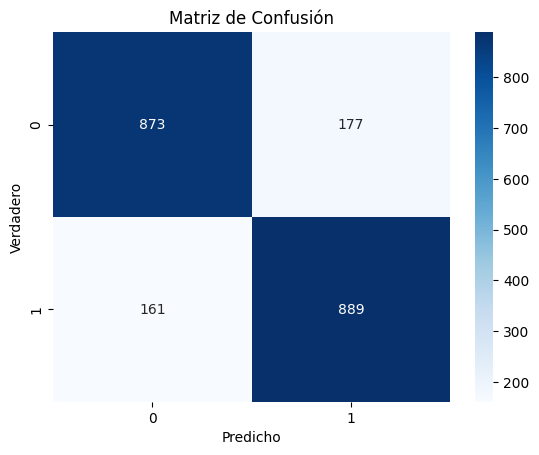

In [ ]:
#nltk.download('stopwords')
stopwords_pt = set(stopwords.words('portuguese'))

# Funciones de limpieza (de celdas previas)
def deaccent(text):
    nfkd = unicodedata.normalize('NFD', str(text))
    return ''.join([c for c in nfkd if not unicodedata.combining(c)])

def basic_clean(text):
    text = str(text)
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"[^\w\s@#?]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    text = deaccent(text)
    return text

def tokenize(text):
    return re.findall(r"@[A-Za-z0-9_]+|#[A-Za-z0-9_]+|\w+|\?", text, flags=re.UNICODE)

# Funciones de detección ampliadas
def contains_insult(text, pre_tokenized=None):
    """Devuelve True si el texto contiene alguna palabra del vocabulario de insultos"""
    tokens = pre_tokenized if pre_tokenized is not None else [t.lower() for t in tokenize(basic_clean(text))]
    return any(t in hybrid_insults for t in tokens)

def contains_excessive_caps(text, pre_tokenized=None):
    """Devuelve True si más del 30% de las palabras alfabéticas están en mayúsculas"""
    tokens = pre_tokenized if pre_tokenized is not None else tokenize(basic_clean(text))
    alpha_tokens = [t for t in tokens if t.isalpha()]
    if not alpha_tokens:
        return False
    upper_count = sum(1 for t in alpha_tokens if t.isupper() and len(t) > 1)
    return (upper_count / len(alpha_tokens)) > 0.3

def contains_question(text, pre_tokenized=None):
    """Devuelve True si el texto contiene múltiples signos de interrogación"""
    tokens = pre_tokenized if pre_tokenized is not None else tokenize(basic_clean(text))
    return sum(1 for t in tokens if t == '?') > 1

def contains_emphatic_punctuation(text, pre_tokenized=None):
    """Devuelve True si el texto contiene puntuación repetida (!!! o ???)"""
    tokens = pre_tokenized if pre_tokenized is not None else tokenize(basic_clean(text))
    return any(t in ['!!!', '????'] for t in tokens)

def contains_negative_emoji(text):
    """Devuelve True si el texto contiene emojis negativos"""
    negative_emojis = ['😡', '🤬', '💩', '👎', '😣', '🤮', '🖕']
    return any(emoji in text for emoji in negative_emojis)

def contains_offensive_ngram(text, pre_tokenized=None):
    """Devuelve True si el texto contiene n-gramas ofensivos"""
    offensive_ngrams = ['filho da', 'vai tomar', 'sem vergonha', 'lixo humano']
    tokens = pre_tokenized if pre_tokenized is not None else tokenize(basic_clean(text))
    text_lower = ' '.join(t.lower() for t in tokens)
    return any(ngram in text_lower for ngram in offensive_ngrams)

def contains_targeted_mention(text, pre_tokenized=None):
    """Devuelve True si una mención (@user) va seguida de un insulto"""
    tokens = pre_tokenized if pre_tokenized is not None else tokenize(basic_clean(text))
    for i, token in enumerate(tokens[:-1]):
        if token.startswith('@') and tokens[i+1].lower() in hybrid_insults:
            return True
    return False

def contains_negation_insult(text, pre_tokenized=None):
    """Devuelve True si hay un insulto sin negación previa"""
    tokens = pre_tokenized if pre_tokenized is not None else tokenize(basic_clean(text))
    negations = ['nao', 'não', 'nunca', 'jamais']
    for i, token in enumerate(tokens):
        if token.lower() in hybrid_insults:
            prev_tokens = tokens[max(0, i-2):i]
            if not any(p.lower() in negations for p in prev_tokens):
                return True
    return False

def contains_political_term(text, pre_tokenized=None):
    """Devuelve True si el texto contiene términos políticos ofensivos"""
    political_insults = ['comunista', 'fascista', 'petista', 'bolsonarista', 'esquerdopata', 'direitopata']
    tokens = pre_tokenized if pre_tokenized is not None else [t.lower() for t in tokenize(basic_clean(text))]
    return any(t in political_insults for t in tokens)


def contains_repeated_insult(text, pre_tokenized=None):
    tokens = pre_tokenized or [t.lower() for t in tokenize(basic_clean(text))]
    return any(tokens.count(t) > 1 for t in hybrid_insults)



# Función de polaridad (de la celda corregida)
def polarity_score(text, pre_tokenized=None):
    if pre_tokenized is None:
        toks = [t.lower() for t in tokenize(basic_clean(text))]
    else:
        toks = pre_tokenized
    if len(toks) == 0:
        return 0
    return sum(token_weights.get(t, 0) for t in toks) / len(toks)

# Función apply_rules mejorada con combinaciones ampliadas
def apply_rules(text, pre_tokenized=None):
    """Clasifica un comentario como ofensivo (1) o no ofensivo (0) basado en reglas jerárquicas"""
    tokens = pre_tokenized or tokenize(basic_clean(text))

    # Regla 1: Insulto sin negación + mayúsculas + emoji negativo
    if (contains_negation_insult(text, tokens) and
        contains_excessive_caps(text, tokens) and
        contains_negative_emoji(text)):
        return 1

    # Regla 2: Insulto sin negación + mención dirigida
    if contains_negation_insult(text, tokens) and contains_targeted_mention(text, tokens):
        return 1

    # Regla 3: Patrón NOUN + ADJ ofensivo
    if has_noun_adj_pattern(text, tokens):
        return 1

    # Regla 4: Patrón VERB + PRON ofensivo
    if has_verb_pron_pattern(text, tokens):
        return 1

    # Regla 5: Insulto sin negación + n-grama ofensivo
    if contains_negation_insult(text, tokens) and contains_offensive_ngram(text, tokens):
        return 1

    # Regla 6: Insulto sin negación + términos políticos
    if contains_negation_insult(text, tokens) and contains_political_term(text, tokens):
        return 1

    # Regla 7: Insulto sin negación + mayúsculas
    if contains_negation_insult(text, tokens) and contains_excessive_caps(text, tokens):
        return 1

    # Regla 8: Insulto sin negación + múltiples interrogaciones
    if contains_negation_insult(text, tokens) and contains_question(text, tokens):
        return 1

    # Regla 9: Insulto sin negación
    if contains_negation_insult(text, tokens):
        return 1

    # Regla 10: Polaridad alta + puntuación enfática
    if polarity_score(text, tokens) > polar_threshold and contains_emphatic_punctuation(text, tokens):
        return 1

    # Regla 11: Polaridad mayor que el umbral
    if polarity_score(text, tokens) > polar_threshold:
        return 1

    return 0

# Pre-tokenizar test_df para optimizar
test_df['tokens'] = test_df['text'].apply(lambda x: tokenize(basic_clean(x)))

# Aplicar reglas al conjunto de test
test_df['pred_rule'] = [apply_rules(t, toks) for t, toks in zip(test_df['text'], test_df['tokens'])]

# Evaluar rendimiento
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
print("Accuracy:", accuracy_score(test_df['label'], test_df['pred_rule']))
print("Precision:", precision_score(test_df['label'], test_df['pred_rule']))
print("Recall:", recall_score(test_df['label'], test_df['pred_rule']))
print("F1-score:", f1_score(test_df['label'], test_df['pred_rule']))
print("Confusion Matrix:\n", confusion_matrix(test_df['label'], test_df['pred_rule']))

# Visualizar matriz de confusión
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(test_df['label'], test_df['pred_rule'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.show()